# Lightweight ASR Pipeline (Kaggle P100) — Whisper Small.EN (Local Common Voice v24 en-AU)

This notebook is a **stable, Kaggle P100–friendly** ASR pipeline using **your local Kaggle dataset layout**:

```
mozilla_commonvoice/
  commonvoice-v24_en-AU/
    audio_files/
    commonvoice-v24_en-AU-split.csv
    commonvoice-v24_en-AU.csv
```

## What it does
- Loads your **local** Common Voice v24 en-AU metadata CSV (and split CSV if present)
- Performs **EDA** (durations, transcript length, common words, waveform preview)
- Applies **speech preprocessing** (mono + 16 kHz resample; optional trimming)
- Fine-tunes **`openai/whisper-small.en`** on your train split
- Evaluates on validation + test with **WER & CER** (normalized)
- Exports **SPSS-like CSV outputs** and an **error analysis** table
- Includes an **inference demo** on a single audio file

## Kaggle optimization
- Avoids TorchCodec/FFmpeg issues by decoding audio using **torchaudio.load**
- Filters long clips (default ≤ 15s)
- Uses fp16 + gradient checkpointing + small batch + grad accumulation
- Saves only a couple checkpoints + auto-prunes older ones


In [1]:
# 0) Install deps (Kaggle) — pinned to avoid dependency conflicts
# NOTE: We pin transformers<5 to stay compatible with Kaggle preinstalls (sentence-transformers, etc.)
# and we remove peft because some Kaggle images ship mismatched peft/transformers versions.
!pip -q uninstall -y peft || true

!pip -q install \
  "transformers==4.44.2" \
  "accelerate==0.34.2" \
  "datasets==2.20.0" \
  "jiwer==3.0.4" \
  "soundfile==0.12.1"

import os, re, random, json, math, shutil, glob
import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Any, Dict, List, Optional
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from jiwer import wer as jiwer_wer, cer as jiwer_cer

print("torch:", torch.__version__)
print("transformers:", __import__("transformers").__version__)
print("cuda:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


2026-02-09 11:48:26.266071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770637706.452846     151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770637706.507595     151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770637706.948151     151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770637706.948195     151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770637706.948198     151 computation_placer.cc:177] computation placer alr

torch: 2.8.0+cu126
transformers: 4.44.2
cuda: True
gpu: Tesla P100-PCIE-16GB


In [2]:
# 1) Reproducibility + output
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

OUTPUT_DIR = "/kaggle/working/whisper_small_en_commonvoice_local"
os.makedirs(OUTPUT_DIR, exist_ok=True)


## 2) Locate your dataset folder automatically

We search common Kaggle roots for:
- `commonvoice-v24_en-AU-split.csv` (preferred) or
- `commonvoice-v24_en-AU.csv`


In [3]:
# 2) Find dataset files
def find_first(patterns, roots=("/kaggle/input", "/kaggle/working", "/kaggle")):
    for root in roots:
        for pat in patterns:
            hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
            if hits:
                return hits[0]
    return None

split_csv = find_first(["commonvoice-v24_en-AU-split.csv", "*split*.csv"])
main_csv  = find_first(["commonvoice-v24_en-AU.csv", "*en-AU*.csv"])

print("Found split CSV:", split_csv)
print("Found main  CSV:", main_csv)

if main_csv is None and split_csv is None:
    raise FileNotFoundError("Could not find your Common Voice CSVs under /kaggle/input or /kaggle/working.")

# infer base directory
base_dir = os.path.dirname(split_csv if split_csv else main_csv)
print("Base dir:", base_dir)

# locate audio directory (your structure uses audio_files)
audio_dir_candidates = [
    os.path.join(base_dir, "audio_files"),
    os.path.join(base_dir, "clips"),
    os.path.join(base_dir, "audio"),
]
audio_dir = next((d for d in audio_dir_candidates if os.path.isdir(d)), None)
print("Audio dir:", audio_dir)
if audio_dir is None:
    raise FileNotFoundError("Could not find audio directory (audio_files/clips/audio).")


Found split CSV: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/commonvoice-v24_en-AU-split.csv
Found main  CSV: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/commonvoice-v24_en-AU.csv
Base dir: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU
Audio dir: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/audio_files


## 3) Load CSV(s) and build train/val/test splits

We support multiple formats:
- If the split CSV exists: it should contain a filename/path and a split column.
- If only the main CSV exists: we look for a `split` column; otherwise do an 80/10/10 split.


In [5]:
# 3) Load CSVs  ✅ (Corrected: handles BOTH long-split and wide-split CSV formats)

def read_csv(path):
    # robust CSV reading (handles different delimiters)
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=";")

df_main  = read_csv(main_csv) if main_csv else None
df_split = read_csv(split_csv) if split_csv else None

print("main columns:", list(df_main.columns)[:30] if df_main is not None else None)
print("split columns:", list(df_split.columns)[:30] if df_split is not None else None)

# Find transcript column
TEXT_COL_CANDIDATES = ["sentence", "text", "transcript", "normalized_text", "utterance"]
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

# Find audio filename/path column
AUDIO_COL_CANDIDATES = ["path", "audio_path", "filename", "file", "clip", "audio"]
def pick_audio_col(cols):
    for c in AUDIO_COL_CANDIDATES:
        if c in cols:
            return c
    return None

def normalize_split_value(x: str) -> str:
    x = str(x).strip().lower()
    if x in ["train", "tr"]:
        return "train"
    if x in ["valid", "val", "validation", "dev", "devel"]:
        return "val"
    if x in ["test", "te"]:
        return "test"
    return x

# -------------------------
# Determine which dataframe to use for splits
# -------------------------
audio_col = None  # we may set it inside wide-split parsing

if df_split is not None:
    df = df_split.copy()

    # Try LONG format split column (values train/val/test in a column)
    split_col = pick_col(df.columns, ["split", "set", "subset", "partition"])
    if split_col is None:
        # infer from column values
        for c in df.columns:
            vals = set(str(v).lower() for v in df[c].dropna().unique()[:50])
            if any(v in vals for v in ["train", "validation", "valid", "dev", "test", "val"]):
                split_col = c
                break

    # If still none -> try WIDE format where columns are train/val/test and cells contain filenames
    if split_col is None:
        wide_split_cols = []
        for c in df.columns:
            if normalize_split_value(c) in ["train", "val", "test"]:
                wide_split_cols.append(c)

        if len(wide_split_cols) > 0:
            print("Detected WIDE split CSV format. Split columns:", wide_split_cols)

            parts = []
            for c in wide_split_cols:
                tmp = df[[c]].dropna().copy()
                tmp = tmp.rename(columns={c: "path"})  # standard filename column
                tmp["split"] = normalize_split_value(c)
                parts.append(tmp)

            df = pd.concat(parts, ignore_index=True)
            split_col = "split"
            audio_col = "path"  # now our audio column is 'path'

        else:
            # No usable split info -> fall back to main CSV (random split later)
            print("WARNING: Split CSV found but no split column detected. Falling back to main CSV.")
            df = df_main.copy()
            split_col = None

else:
    df = df_main.copy()
    split_col = pick_col(df.columns, ["split", "set", "subset", "partition"])

# -------------------------
# Transcript + audio columns
# -------------------------
text_col = pick_col(df.columns, TEXT_COL_CANDIDATES) or (
    pick_col(df_main.columns, TEXT_COL_CANDIDATES) if df_main is not None else None
)
if text_col is None:
    raise ValueError("Could not find transcript column. Try renaming it to 'sentence' or 'text'.")

# if audio_col not already fixed (wide split case), detect it normally
if audio_col is None:
    audio_col = pick_audio_col(df.columns) or (
        pick_audio_col(df_main.columns) if df_main is not None else None
    )
if audio_col is None:
    raise ValueError("Could not find audio path/filename column. Try 'path' or 'filename'.")

print("Using text column:", text_col)
print("Using audio column:", audio_col)
print("Using split column:", split_col)

# Map split values if split column exists
if split_col is not None and split_col in df.columns:
    df[split_col] = df[split_col].apply(normalize_split_value)

# If df_split lacks transcript, merge transcript from main by a key (audio_col)
if df_split is not None and df_main is not None and text_col not in df_split.columns:
    key = audio_col
    if key in df_main.columns and key in df.columns:
        df = df.merge(df_main[[key, text_col]], on=key, how="left")

# -------------------------
# Build absolute audio paths
# -------------------------
def to_abs_audio_path(x):
    if pd.isna(x):
        return None
    x = str(x)
    # if already absolute
    if os.path.isabs(x) and os.path.exists(x):
        return x
    # try joining base_dir
    p1 = os.path.join(base_dir, x)
    if os.path.exists(p1):
        return p1
    # assume filename in audio_dir
    p2 = os.path.join(audio_dir, os.path.basename(x))
    if os.path.exists(p2):
        return p2
    # handle nested relative like "clips/xxx.mp3" or "audio_files/xxx"
    p3 = os.path.join(base_dir, os.path.normpath(x))
    if os.path.exists(p3):
        return p3
    return p2  # last resort

df["audio_path"] = df[audio_col].apply(to_abs_audio_path)
df["transcript"] = df[text_col].astype(str)

# Drop missing audio files
df = df[df["audio_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)

print("Rows with existing audio:", len(df))
df.head()

main columns: ['Unnamed: 0', 'client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'duration_ms']
split columns: ['Unnamed: 0', 'client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'duration_ms']
Using text column: sentence
Using audio column: path
Using split column: None
Rows with existing audio: 55673


,Unnamed: 0,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,duration_ms,audio_path,transcript
0,182,0621ad6390e651ff1e39b23f74e8d624bd8ba0957d6a19...,common_voice_en_30513358.mp3,1f08423cd2153df43fb7c18ddd24edfea7be733046c26d...,Princess Vilas herself also contributed person...,NaN,4,0,teens,male_masculine,Australian English,NaN,en,NaN,7.387500,/kaggle/input/mozilla-commonvoice/commonvoice-...,Princess Vilas herself also contributed person...
1,725,18bea6bb076cd9638518d93b4af353c3c329d059789e11...,common_voice_en_43618790.mp3,fe3f016c86bea44ab149bc2537de58f16051d8274099a7...,He has also served in the Chamber of Deputies.,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,6.307500,/kaggle/input/mozilla-commonvoice/commonvoice-...,He has also served in the Chamber of Deputies.
2,885,1db7f61c407a3cdce51e21ae1871ef9ae3ed74d79415ba...,common_voice_en_21099981.mp3,48e620d96dda152eeec48e28f7b0dde29625591bdc44cd...,Most of his subjects were found in Devon and C...,NaN,2,0,thirties,male_masculine,Australian English,NaN,en,NaN,7.949625,/kaggle/input/mozilla-commonvoice/commonvoice-...,Most of his subjects were found in Devon and C...
3,984,2144a6feb6a906b220cbba00f37b56084bd2d60cce773e...,common_voice_en_39588772.mp3,e3d037f2c263d604b0bb1ef837b1fc7ee7f80d5336031c...,Shots rang out as they fled towards the Austri...,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,5.515500,/kaggle/input/mozilla-commonvoice/commonvoice-...,Shots rang out as they fled towards the Austri...
4,1021,22b4048e01f359c779cf9a692f5da7512bfd7ef8c9fff2...,common_voice_en_37211578.mp3,cdfb0356e09201212c123e83ab27e43c48a62b6ce8520d...,The system is based on electromagnetic induction.,NaN,2,0,NaN,NaN,Australian English,NaN,en,NaN,4.055656,/kaggle/input/mozilla-commonvoice/commonvoice-...,The system is based on electromagnetic induction.


In [6]:
# 4) Filters, sampling, and split creation
MIN_AUDIO_SEC = 0.2
MAX_AUDIO_SEC = 15.0

def get_duration_sec(path: str):
    try:
        info = torchaudio.info(path)
        return info.num_frames / info.sample_rate
    except Exception:
        return None

def normalize_for_metrics(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\[[^\]]*\]", " ", s)
    s = re.sub(r"[^a-z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# compute durations (fast)
df["duration"] = df["audio_path"].apply(get_duration_sec)
df = df.dropna(subset=["duration"]).reset_index(drop=True)
df = df[(df["duration"] >= MIN_AUDIO_SEC) & (df["duration"] <= MAX_AUDIO_SEC)].reset_index(drop=True)

# remove empty transcripts
df["transcript"] = df["transcript"].astype(str).str.strip()
df = df[df["transcript"].str.len() >= 2].reset_index(drop=True)

df["text_norm"] = df["transcript"].apply(normalize_for_metrics)

print("After filtering:", len(df), "rows")
df[["audio_path","transcript","duration"]].head()


/tmp/ipykernel_151/1245540624.py:7: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torchaudio.io.St

After filtering: 55668 rows


,audio_path,transcript,duration
0,/kaggle/input/mozilla-commonvoice/commonvoice-...,Princess Vilas herself also contributed person...,7.380
1,/kaggle/input/mozilla-commonvoice/commonvoice-...,He has also served in the Chamber of Deputies.,6.300
2,/kaggle/input/mozilla-commonvoice/commonvoice-...,Most of his subjects were found in Devon and C...,7.944
3,/kaggle/input/mozilla-commonvoice/commonvoice-...,Shots rang out as they fled towards the Austri...,5.508
4,/kaggle/input/mozilla-commonvoice/commonvoice-...,The system is based on electromagnetic induction.,4.032


In [8]:
# Create train/val/test splits
# If a split column exists -> use it. Otherwise do 80/10/10.
if split_col is not None and split_col in df.columns and df[split_col].isin(["train","val","test"]).any():
    train_df = df[df[split_col] == "train"].copy()
    val_df   = df[df[split_col] == "val"].copy()
    test_df  = df[df[split_col] == "test"].copy()
else:
    df_shuf = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    n = len(df_shuf)
    n_train = int(0.8*n)
    n_val = int(0.1*n)
    train_df = df_shuf.iloc[:n_train].copy()
    val_df = df_shuf.iloc[n_train:n_train+n_val].copy()
    test_df = df_shuf.iloc[n_train+n_val:].copy()

print("Split sizes:", len(train_df), len(val_df), len(test_df))

# Optional: cap sizes for faster experiments (increase later for better WER/CER)
N_TRAIN = min(6000, len(train_df))
N_VAL   = min(500, len(val_df))
N_TEST  = min(500, len(test_df))

train_df = train_df.sample(n=N_TRAIN, random_state=SEED) if len(train_df) > N_TRAIN else train_df
val_df   = val_df.sample(n=N_VAL,   random_state=SEED) if len(val_df) > N_VAL else val_df
test_df  = test_df.sample(n=N_TEST,  random_state=SEED) if len(test_df) > N_TEST else test_df

print("Using subset sizes:", len(train_df), len(val_df), len(test_df))


Split sizes: 44534 5566 5568
Using subset sizes: 6000 500 500


## 5) EDA (durations, transcript lengths, common words, waveform preview)



--- TRAIN ---
N: 6000
Duration mean: 5.037 p95: 7.968
Text len mean: 55.95 p95: 89.0
Top 10 words: [('the', 4050), ('of', 1458), ('a', 1433), ('and', 1330), ('to', 1227), ('in', 1188), ('is', 1065), ('was', 879), ('he', 622), ('it', 584)]

--- VAL ---
N: 500
Duration mean: 5.01 p95: 8.209
Text len mean: 55.24 p95: 88.0
Top 10 words: [('the', 327), ('of', 117), ('a', 114), ('in', 107), ('and', 103), ('to', 92), ('is', 78), ('was', 76), ('he', 51), ('it', 48)]

--- TEST ---
N: 500
Duration mean: 5.102 p95: 8.136
Text len mean: 55.63 p95: 91.0
Top 10 words: [('the', 341), ('of', 113), ('a', 111), ('to', 108), ('and', 97), ('is', 97), ('in', 91), ('was', 73), ('he', 61), ('it', 54)]


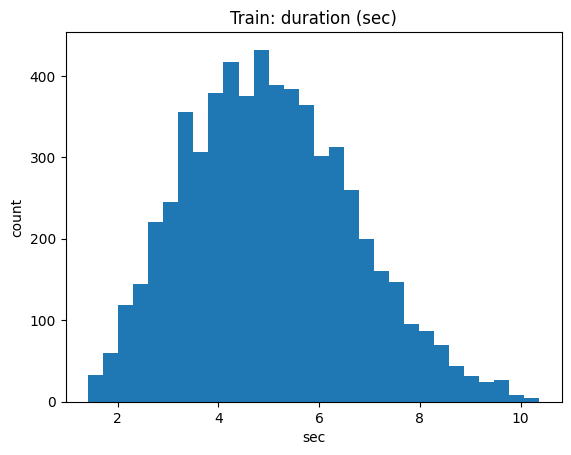

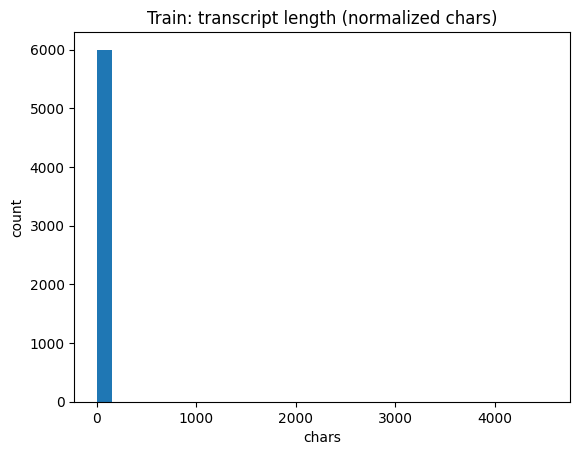

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

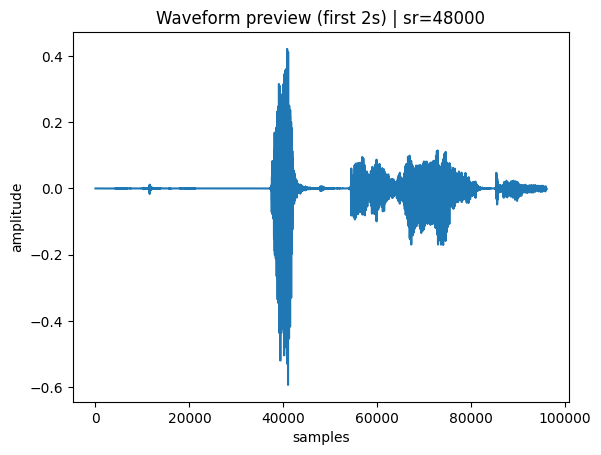

Example transcript: But before I go, I want to tell you a little story.


In [9]:
from collections import Counter

def eda_basic(df_, name):
    print(f"\n--- {name} ---")
    print("N:", len(df_))
    print("Duration mean:", round(df_['duration'].mean(), 3), "p95:", round(df_['duration'].quantile(0.95), 3))
    tl = df_["text_norm"].str.len()
    print("Text len mean:", round(tl.mean(), 2), "p95:", round(tl.quantile(0.95), 2))
    words = Counter(" ".join(df_["text_norm"].tolist()).split())
    print("Top 10 words:", words.most_common(10))

eda_basic(train_df, "TRAIN")
eda_basic(val_df, "VAL")
eda_basic(test_df, "TEST")

plt.figure()
plt.hist(train_df["duration"], bins=30)
plt.title("Train: duration (sec)")
plt.xlabel("sec"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(train_df["text_norm"].str.len(), bins=30)
plt.title("Train: transcript length (normalized chars)")
plt.xlabel("chars"); plt.ylabel("count")
plt.show()

# waveform preview
ex_path = train_df.iloc[0]["audio_path"]
wav, sr = torchaudio.load(ex_path)
wav = wav.mean(dim=0) if wav.shape[0] > 1 else wav.squeeze(0)
plt.figure()
plt.plot(wav[: min(len(wav), sr*2)].numpy())
plt.title(f"Waveform preview (first 2s) | sr={sr}")
plt.xlabel("samples"); plt.ylabel("amplitude")
plt.show()

print("Example transcript:", train_df.iloc[0]["transcript"])


## 6) Preprocessing (torchaudio decoding) + Torch Dataset
We decode audio ourselves to avoid TorchCodec/FFmpeg. We resample to **16 kHz** and convert to **mono**.


In [10]:
# Audio preprocessing
_resamplers = {}

def trim_silence(wave: torch.Tensor, thr: float = 0.01):
    if wave.numel() < 10:
        return wave
    mask = wave.abs() > thr
    if mask.any():
        i0 = int(mask.argmax())
        i1 = int(len(mask) - mask.flip(0).argmax())
        return wave[i0:i1]
    return wave

def load_audio_16k_mono(path: str, do_trim: bool = False):
    wav, sr = torchaudio.load(path)  # [C, T]
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    wav = wav.squeeze(0)
    if sr != 16000:
        key = (sr, 16000)
        if key not in _resamplers:
            _resamplers[key] = torchaudio.transforms.Resample(sr, 16000)
        wav = _resamplers[key](wav)
    if do_trim:
        wav = trim_silence(wav)
    return wav

class ASRDataset(torch.utils.data.Dataset):
    def __init__(self, df_: pd.DataFrame):
        self.df = df_.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        return {"audio_path": r.audio_path, "text": r.transcript, "text_norm": r.text_norm}

train_ds = ASRDataset(train_df)
val_ds   = ASRDataset(val_df)
test_ds  = ASRDataset(test_df)

len(train_ds), len(val_ds), len(test_ds)


(6000, 500, 500)

## 7) Whisper Small.EN model + collator (fast, stable)

We compute Whisper log-mel features on the fly (no large feature files saved).


In [11]:
MODEL_NAME = "openai/whisper-small.en"
processor = WhisperProcessor.from_pretrained(MODEL_NAME)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

# Force English transcription prompts
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")

# Kaggle stability
model.config.use_cache = False
model.gradient_checkpointing_enable()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

@dataclass
class DataCollatorWhisper:
    processor: WhisperProcessor
    do_trim: bool = False
    max_label_length: int = 256

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        audio_arrays = []
        texts = []
        for f in features:
            wav = load_audio_16k_mono(f["audio_path"], do_trim=self.do_trim)
            audio_arrays.append(wav.numpy())
            texts.append(f["text"])

        # input features (log-mel)
        inputs = self.processor.feature_extractor(
            audio_arrays, sampling_rate=16000, return_tensors="pt"
        )
        input_features = inputs["input_features"]

        # labels
        labels = self.processor.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_label_length,
            return_tensors="pt",
        )["input_ids"]

        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        # remove BOS if present everywhere
        bos = self.processor.tokenizer.bos_token_id
        if bos is not None and (labels[:, 0] == bos).all():
            labels = labels[:, 1:]

        return {"input_features": input_features, "labels": labels}

data_collator = DataCollatorWhisper(processor=processor, do_trim=False, max_label_length=256)
print("Model ready.")


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model ready.


## 8) Metrics (WER + CER) — normalized


In [12]:
def normalize_for_metrics(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\[[^\]]*\]", " ", s)
    s = re.sub(r"[^a-z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def compute_metrics(pred):
    pred_ids = pred.predictions
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    # labels
    label_ids = pred.label_ids.copy()
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    pred_norm = [normalize_for_metrics(s) for s in pred_str]
    lab_norm  = [normalize_for_metrics(s) for s in label_str]

    return {
        "wer_norm": jiwer_wer(lab_norm, pred_norm),
        "cer_norm": jiwer_cer(lab_norm, pred_norm),
    }


## 9) Training (P100-friendly)


In [15]:
BATCH_SIZE = 4
GRAD_ACCUM = 4   # effective batch 16
EPOCHS = 2
LR = 1e-5

def prune_checkpoints(folder: str, keep_last_n: int = 1):
    if not os.path.isdir(folder):
        return
    cks = [d for d in os.listdir(folder) if d.startswith("checkpoint-")]
    if len(cks) <= keep_last_n:
        return
    cks = sorted(cks, key=lambda x: int(x.split("-")[-1]))
    for ck in cks[:-keep_last_n]:
        shutil.rmtree(os.path.join(folder, ck), ignore_errors=True)

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    warmup_steps=100,
    num_train_epochs=EPOCHS,
    fp16=True,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=200,
    save_steps=200,
    logging_steps=50,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=225,
    load_best_model_at_end=True,
    metric_for_best_model="wer_norm",
    greater_is_better=False,
    report_to="none",
    remove_unused_columns=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

trainer

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [16]:
print(train_ds[0].keys())
print(train_ds[0])

dict_keys(['audio_path', 'text', 'text_norm'])
{'audio_path': '/kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/audio_files/common_voice_en_681249.mp3', 'text': 'But before I go, I want to tell you a little story.', 'text_norm': 'but before i go i want to tell you a little story'}


In [17]:
# 10) Train
train_result = trainer.train()
trainer.save_model(os.path.join(OUTPUT_DIR, "best_model"))
prune_checkpoints(OUTPUT_DIR, keep_last_n=1)
print(train_result)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Step,Training Loss,Validation Loss,Wer Norm,Cer Norm
200,0.304100,0.287158,0.080148,0.033055
400,0.193400,0.263983,0.082409,0.033055
600,0.114200,0.263164,0.083642,0.033525


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 2700

TrainOutput(global_step=750, training_loss=0.48373500442504885, metrics={'train_runtime': 4547.3448, 'train_samples_per_second': 2.639, 'train_steps_per_second': 0.165, 'total_flos': 3.46302480384e+18, 'train_loss': 0.48373500442504885, 'epoch': 2.0})


In [18]:
# 11) Evaluate + export CSV tables
val_metrics = trainer.evaluate()
test_metrics = trainer.evaluate(test_ds)

print("VAL:", val_metrics)
print("TEST:", test_metrics)

pd.DataFrame([val_metrics]).to_csv(os.path.join(OUTPUT_DIR, "val_metrics.csv"), index=False)
pd.DataFrame([test_metrics]).to_csv(os.path.join(OUTPUT_DIR, "test_metrics.csv"), index=False)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

VAL: {'eval_loss': 0.2871577739715576, 'eval_wer_norm': 0.08014796547472257, 'eval_cer_norm': 0.03305455993628036, 'eval_runtime': 139.8976, 'eval_samples_per_second': 3.574, 'eval_steps_per_second': 0.894, 'epoch': 2.0}
TEST: {'eval_loss': 0.31568214297294617, 'eval_wer_norm': 0.09238349414904537, 'eval_cer_norm': 0.03695847564263886, 'eval_runtime': 140.9249, 'eval_samples_per_second': 3.548, 'eval_steps_per_second': 0.887, 'epoch': 2.0}


## 12) Error analysis (export top errors)


In [19]:
def transcribe_subset(df_small: pd.DataFrame, batch_size: int = 4):
    model.eval()
    preds, refs = [], []
    for i in range(0, len(df_small), batch_size):
        chunk = df_small.iloc[i:i+batch_size]
        audio_arrays = [load_audio_16k_mono(p).numpy() for p in chunk.audio_path.tolist()]
        feats = processor.feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt")
        input_features = feats["input_features"].to(device)
        with torch.no_grad():
            ids = model.generate(input_features, max_length=225)
        pred_text = processor.tokenizer.batch_decode(ids, skip_special_tokens=True)
        preds.extend(pred_text)
        refs.extend(chunk.transcript.tolist())
    return refs, preds

sample_n = min(80, len(test_df))
sample_df = test_df.sample(sample_n, random_state=SEED).reset_index(drop=True)
refs, preds = transcribe_subset(sample_df, batch_size=4)

err = pd.DataFrame({"reference": refs, "prediction": preds})
err["ref_norm"] = err["reference"].apply(normalize_for_metrics)
err["pred_norm"] = err["prediction"].apply(normalize_for_metrics)
err["wer_sentence_norm"] = [jiwer_wer([r], [p]) for r, p in zip(err["ref_norm"], err["pred_norm"])]
err = err.sort_values("wer_sentence_norm", ascending=False)

err.to_csv(os.path.join(OUTPUT_DIR, "error_analysis.csv"), index=False)
err.head(20)


,reference,prediction,ref_norm,pred_norm,wer_sentence_norm
64,"How they managed together, I can’t tell.","How they manage together, I can't tell you.",how they managed together i can t tell,how they manage together i can't tell you,0.500000
26,Many also extend the backcorners of the headsh...,Many also extend the back corners of the head...,many also extend the backcorners of the headsh...,many also extend the back corners of the head ...,0.461538
12,You don’t like him?,You don't like him?,you don t like him,you don't like him,0.400000
0,He eventually found his headphones in the larder.,He eventually found his head friends in the l...,he eventually found his headphones in the larder,he eventually found his head friends in the la...,0.375000
4,The latter being a duet with Marcella Detroit.,The latter being duo with Marcela Detroit.,the latter being a duet with marcella detroit,the latter being duo with marcela detroit,0.375000
7,"Mniarogekko chahoua, like all of the ""New Cale...",Many regard karuhua like all the New Caledoni...,mniarogekko chahoua like all of the new caledo...,many regard karuhua like all the new caledonia...,0.363636
60,The origin of the Reddy has been linked to the...,The origin of the ready has been linked to th...,the origin of the reddy has been linked to the...,the origin of the ready has been linked to the...,0.357143
28,"Initially, Scottsbluff Army Airfield was a sat...","Initially, Scott's Bluff Army airfield was a ...",initially scottsbluff army airfield was a sate...,initially scott's bluff army airfield was a sa...,0.307692
2,"A reply came back, 'Buy vice locally'.","A reply came back, by Vice-Nucally.",a reply came back 'buy vice locally',a reply came back by vice nucally,0.285714
35,This is known as the Ashes Trophy.,This is known as Ash's Trophy.,this is known as the ashes trophy,this is known as ash's trophy,0.285714


## 13) Inference demo (single file)


In [20]:
def transcribe_file(path: str) -> str:
    wav = load_audio_16k_mono(path)
    feats = processor.feature_extractor([wav.numpy()], sampling_rate=16000, return_tensors="pt")
    input_features = feats["input_features"].to(device)
    with torch.no_grad():
        ids = model.generate(input_features, max_length=225)
    return processor.tokenizer.decode(ids[0], skip_special_tokens=True)

example_path = test_df.iloc[0]["audio_path"]
print("Audio:", example_path)
print("Reference:", test_df.iloc[0]["transcript"])
print("Prediction:", transcribe_file(example_path))


Audio: /kaggle/input/mozilla-commonvoice/commonvoice-v24_en-AU/audio_files/common_voice_en_594722.mp3
Reference: A blond man plays guitar with one other player barely visible out of frame.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Prediction:  A broad man plays guitar with one other player, barely visible out of frame.
